# Evaluation Of Duet Benchmarking Results from Distributed Database "Cassandra"

### Imports

In [187]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import os
from pathlib import Path

In [188]:
# cwd = Path.cwd()
# filepath = os.path.join(cwd, "Results", "1.25mCops_4t", "AA", "run_measurements3.csv")
# print(filepath)
# df3 = pd.read_csv(filepath)

In [189]:
# cwd = Path.cwd()
# filepath = os.path.join(cwd, "Results", "1.25mCops_4t", "AA", "run_measurements2.csv")
# print(filepath)
# df2 = pd.read_csv(filepath)

### Import Benchmarking Measurements as csv file and create Pandas Dataframe for further Analysis

In [190]:
cwd = Path.cwd()
filepath = os.path.join(cwd, "Results", "1.25mCops_4t", "AB", "run_measurements2.csv")
print(filepath)
df = pd.read_csv(filepath)

C:\Users\Felix Medicus\Desktop\Thesis_MCC\DuetBenchmarking\Results\Results\1.25mCops_4t\AB\run_measurements2.csv


In [191]:
# df = pd.concat([df1, df2, df3])
# df = df1

### Set Versions as Variables

In [192]:
workloadLoad = "Workload C: 100% Insert"
workloadRun = "Workload C: 100% Read"
phase = "Run"
versionA = "Version A: Cassandra 4.0.4"
versionB = "Version B: Cassandra 3.0.27"

### Insert latencies in ms into the measurement table

In [193]:
df["latency_ms"] = (df["received"]- df["sent"])/1000000

In [194]:
df["sent_ms"] = df["sent"].div(1000000)
df["received_ms"] = df["received"].div(1000000)

In [195]:
df.describe()

,queryId,sent,received,latency_ms,sent_ms,received_ms
count,2.500000e+06,2.500000e+06,2.500000e+06,2.500000e+06,2.500000e+06,2.500000e+06
mean,6.249995e+05,3.024905e+12,3.024912e+12,7.614481e+00,3.024905e+06,3.024912e+06
std,3.608440e+05,2.311236e+11,2.311230e+11,2.377666e+01,2.311236e+05,2.311230e+05
min,0.000000e+00,2.609811e+12,2.609878e+12,6.568540e-01,2.609811e+06,2.609878e+06
25%,3.124998e+05,2.818725e+12,2.818729e+12,1.500081e+00,2.818725e+06,2.818729e+06
50%,6.249995e+05,3.026018e+12,3.026022e+12,2.372960e+00,3.026018e+06,3.026022e+06
75%,9.374992e+05,3.226563e+12,3.226573e+12,4.208124e+00,3.226563e+06,3.226573e+06
max,1.249999e+06,3.435055e+12,3.435056e+12,1.123855e+03,3.435055e+06,3.435056e+06


In [196]:
df = df.sort_values(by="sent", ascending=True)
df.head()

,workerId,queryType,queryId,sent,received,target-region,latency_ms,sent_ms,received_ms
3,w1-vA,SELECT,0,2609811010895,2609889060193,unknown,78.049298,2.609811e+06,2.609889e+06
4,w1-vB,SELECT,625002,2609812018573,2609906358459,unknown,94.339886,2.609812e+06,2.609906e+06
0,w1-vA,SELECT,625002,2609812201792,2609877692644,unknown,65.490852,2.609812e+06,2.609878e+06
2,w1-vB,SELECT,312501,2609812287598,2609884903063,unknown,72.615465,2.609812e+06,2.609885e+06
1,w1-vA,SELECT,312501,2609812489829,2609883467689,unknown,70.977860,2.609812e+06,2.609883e+06


### Restructure Timeline

In [197]:
firstSent = df["sent"].min()
df["sent_sec"] = (df["sent"] - firstSent)/1000000/1000

### Return benchmark run time (First request send to last response received)

In [198]:
totalTime = df["sent"].max() - df["sent"].min()
print(totalTime/1000000/1000, "seconds", "or", totalTime/1000000/1000/60, "m") 

825.244022618 seconds or 13.754067043633334 m


### Prune Measurements and print new run time for pruned benchmark (Remove first and last 100 seconds)

In [199]:
dfPruned = df.loc[(df["sent_sec"] > 200) & (df["sent_sec"] < (totalTime/1000000/1000) - 100)]

In [200]:
totalTime = dfPruned["sent"].max() - dfPruned["sent"].min()
print("Pruned time:\n",totalTime/1000000/1000, "seconds", "or", totalTime/1000000/1000/60, "minutes") 

Pruned time:
 525.2436994789999 seconds or 8.754061657983332 minutes


### Create subsets of dataframe (for Version A and B, and for each worker for Version A and B) 

In [201]:
dfA1 = dfPruned.loc[(dfPruned["workerId"] == "w1-vA")]
dfA2 = dfPruned.loc[(dfPruned["workerId"] == "w2-vA")]
dfA3 = dfPruned.loc[(dfPruned["workerId"] == "w3-vA")]
dfB1 = dfPruned.loc[(dfPruned["workerId"] == "w1-vB")]
dfB2 = dfPruned.loc[(dfPruned["workerId"] == "w2-vB")]
dfB3 = dfPruned.loc[(dfPruned["workerId"] == "w3-vB")]
dfA = dfPruned.loc[(dfPruned["workerId"] == "w1-vA") | (dfPruned["workerId"] == "w2-vA") | (dfPruned["workerId"] == "w3-vA")]
dfB = dfPruned.loc[(dfPruned["workerId"] == "w1-vB") | (dfPruned["workerId"] == "w2-vB") | (dfPruned["workerId"] == "w3-vB")]
dfARaw = df.loc[(df["workerId"] == "w1-vA") | (df["workerId"] == "w2-vA") | (df["workerId"] == "w3-vA")]
dfBRaw = df.loc[(df["workerId"] == "w1-vB") | (df["workerId"] == "w2-vB") | (df["workerId"] == "w3-vB")]

In [202]:
dfARaw.describe()

,queryId,sent,received,latency_ms,sent_ms,received_ms,sent_sec
count,1.250000e+06,1.250000e+06,1.250000e+06,1.250000e+06,1.250000e+06,1.250000e+06,1.250000e+06
mean,6.249995e+05,3.075021e+12,3.075028e+12,7.855421e+00,3.075021e+06,3.075028e+06,4.652096e+02
std,3.608441e+05,2.243542e+11,2.243523e+11,2.473396e+01,2.243542e+05,2.243523e+05,2.243542e+02
min,0.000000e+00,2.609811e+12,2.609878e+12,6.568540e-01,2.609811e+06,2.609878e+06,0.000000e+00
25%,3.124998e+05,2.887242e+12,2.887245e+12,1.263797e+00,2.887242e+06,2.887245e+06,2.774312e+02
50%,6.249995e+05,3.079802e+12,3.079812e+12,1.866439e+00,3.079802e+06,3.079812e+06,4.699913e+02
75%,9.374992e+05,3.272755e+12,3.272758e+12,3.445619e+00,3.272755e+06,3.272758e+06,6.629442e+02
max,1.249999e+06,3.435055e+12,3.435056e+12,8.162163e+02,3.435055e+06,3.435056e+06,8.252440e+02


In [203]:
dfBRaw.describe()

,queryId,sent,received,latency_ms,sent_ms,received_ms,sent_sec
count,1.250000e+06,1.250000e+06,1.250000e+06,1.250000e+06,1.250000e+06,1.250000e+06,1.250000e+06
mean,6.249995e+05,2.974789e+12,2.974796e+12,7.373541e+00,2.974789e+06,2.974796e+06,3.649780e+02
std,3.608441e+05,2.268882e+11,2.268889e+11,2.277663e+01,2.268882e+05,2.268889e+05,2.268882e+02
min,0.000000e+00,2.609812e+12,2.609885e+12,6.701900e-01,2.609812e+06,2.609885e+06,1.007678e-03
25%,3.124998e+05,2.746653e+12,2.746664e+12,1.918648e+00,2.746653e+06,2.746664e+06,1.368421e+02
50%,6.249995e+05,2.962184e+12,2.962190e+12,2.863791e+00,2.962184e+06,2.962190e+06,3.523731e+02
75%,9.374992e+05,3.175823e+12,3.175833e+12,4.738437e+00,3.175823e+06,3.175833e+06,5.660120e+02
max,1.249999e+06,3.386219e+12,3.386221e+12,1.123855e+03,3.386219e+06,3.386221e+06,7.764075e+02


In [204]:
dfA.describe()

,queryId,sent,received,latency_ms,sent_ms,received_ms,sent_sec
count,8.507560e+05,8.507560e+05,8.507560e+05,850756.000000,8.507560e+05,8.507560e+05,850756.000000
mean,6.226897e+05,3.075084e+12,3.075091e+12,7.405799,3.075084e+06,3.075091e+06,465.272562
std,3.549560e+05,1.516297e+11,1.516295e+11,23.083911,1.516297e+05,1.516295e+05,151.629676
min,4.656500e+04,2.809813e+12,2.809815e+12,0.656854,2.809813e+06,2.809815e+06,200.001670
25%,2.611612e+05,2.943033e+12,2.943038e+12,1.296311,2.943033e+06,2.943038e+06,333.222316
50%,6.722735e+05,3.075251e+12,3.075254e+12,1.962713,3.075251e+06,3.075254e+06,465.440258
75%,8.871308e+05,3.207754e+12,3.207757e+12,3.572696,3.207754e+06,3.207757e+06,597.942961
max,1.200429e+06,3.335055e+12,3.335172e+12,412.005609,3.335055e+06,3.335172e+06,725.243705


In [205]:
dfB.describe()

,queryId,sent,received,latency_ms,sent_ms,received_ms,sent_sec
count,7.732890e+05,7.732890e+05,7.732890e+05,773289.000000,7.732890e+05,7.732890e+05,773289.000000
mean,6.670303e+05,3.076388e+12,3.076396e+12,8.148492,3.076388e+06,3.076396e+06,466.577287
std,3.534810e+05,1.518259e+11,1.518257e+11,23.517447,1.518259e+05,1.518257e+05,151.825860
min,1.003820e+05,2.809811e+12,2.809816e+12,0.670190,2.809811e+06,2.809816e+06,200.000005
25%,4.141870e+05,2.944226e+12,2.944233e+12,1.959716,2.944226e+06,2.944233e+06,334.415168
50%,6.128820e+05,3.078662e+12,3.078674e+12,2.949828,3.078662e+06,3.078674e+06,468.850630
75%,9.209490e+05,3.208469e+12,3.208474e+12,4.943272,3.208469e+06,3.208474e+06,598.657697
max,1.233915e+06,3.335053e+12,3.335229e+12,636.337333,3.335053e+06,3.335229e+06,725.242155


### Calculate Percentiles

In [206]:
ninetyA = dfA["latency_ms"].dropna().quantile([.9])
ninetynineA = dfA["latency_ms"].dropna().quantile([.99])
print("90% percentile versionA --> ", ninetyA, "\n99% percentile Version A --> ", ninetynineA)


90% percentile versionA -->  0.9    8.476059
Name: latency_ms, dtype: float64 
99% percentile Version A -->  0.99    134.955647
Name: latency_ms, dtype: float64


In [207]:
ninetyB = dfB["latency_ms"].dropna().quantile([.9])
ninetynineB = dfB["latency_ms"].dropna().quantile([.99])
print("90% percentile versionA --> ", ninetyB, "\n99% percentile Version A --> ", ninetynineB)

90% percentile versionA -->  0.9    8.669244
Name: latency_ms, dtype: float64 
99% percentile Version A -->  0.99    133.523586
Name: latency_ms, dtype: float64


### Min. Latencies for Worker 2 (A & B)

In [208]:
dfA3.loc[dfA3["latency_ms"].idxmin()]

workerId                  w3-vA
queryType                SELECT
queryId                  768905
sent              3053493007485
received          3053493664339
target-region           unknown
latency_ms             0.656854
sent_ms          3053493.007485
received_ms      3053493.664339
sent_sec             443.681997
Name: 2108708, dtype: object

In [209]:
dfB1.loc[dfB1["latency_ms"].idxmin()]

workerId                  w1-vB
queryType                SELECT
queryId                  276576
sent              3279034844884
received          3279035515074
target-region           unknown
latency_ms              0.67019
sent_ms          3279034.844884
received_ms      3279035.515074
sent_sec             669.223834
Name: 687812, dtype: object

In [210]:
df[df.received == 999999999999999999].shape[0]


0

### Some checks

#### Time difference in ms when first query was sent by worker-1 to Version A and B 

In [211]:

dfA2["sent"].min() - dfB2["sent"].min()

-2173331

#### Time difference in ms when last query was sent by worker-1 to Version A and B 

In [212]:
dfA1["sent"].max() - dfB1["sent"].max() 


1549428

## Create Figures 

### Create Boxplots

In [213]:
sns.set_theme(style="darkgrid")
print(len(dfA))

850756


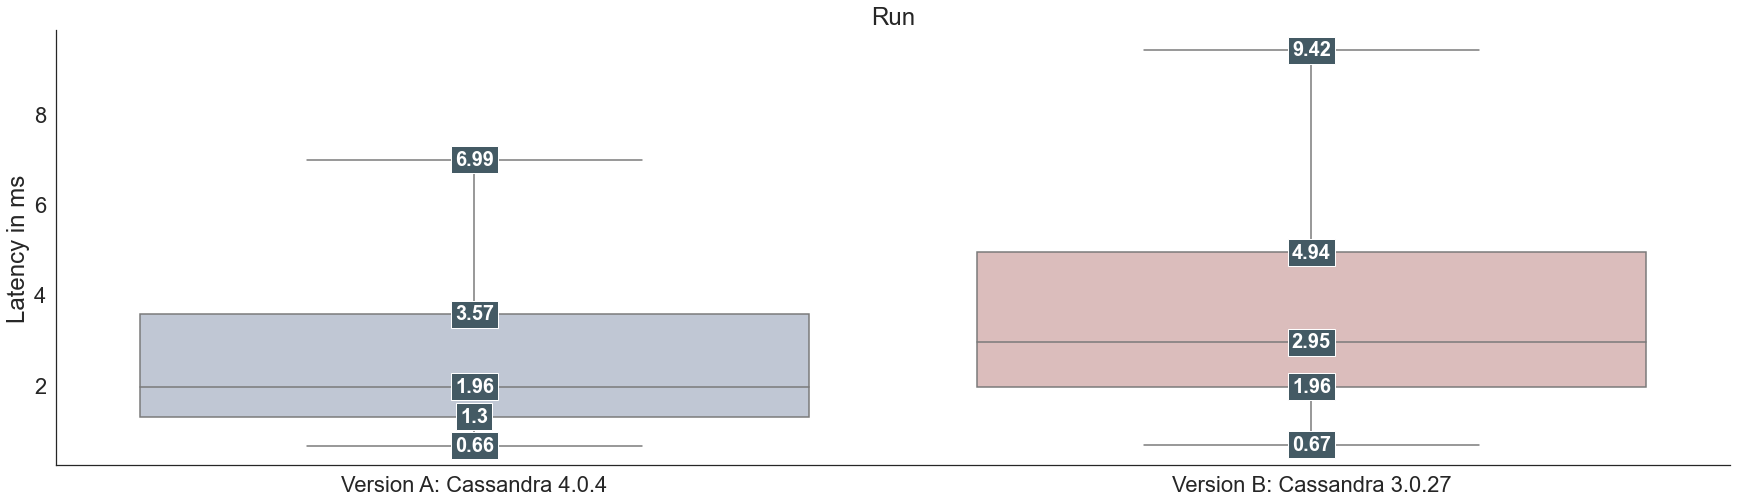

In [214]:

combined_dfs = pd.DataFrame({versionA: dfA['latency_ms'],
                             versionB: dfB['latency_ms']})
                             
sns.set_style('white')
sns.set_context('notebook', font_scale=2.0)

box_plot = sns.boxplot(data=combined_dfs, color='white', showfliers=False, whis=1.5,palette="vlag").set_title(phase)




ax = box_plot.axes
ax.set_ylabel("Latency in ms")
lines = ax.get_lines()

categories = ax.get_xticks()

for i in range(0,5):
    for cat in categories:

        y = round(lines[(i+cat*5)].get_ydata()[0],2) 

        ax.text(
            cat, 
            y, 
            f'{y}', 
            ha='center', 
            va='center', 
            fontweight='bold', 
            size=20,
            color='white',
            bbox=dict(facecolor='#445A64'))


sns.despine()



In [215]:
sns.set_context("notebook")
sns.set(rc={'figure.figsize':(30,8)})
print(len(df))

2500000


### Create Lineplot comparing latencies of Version A and B

C:\Users\Felix Medicus\AppData\Local\Temp\ipykernel_13972\2150790566.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subchartA["100sec_average"] = subchartA.latency_ms.rolling(5000).mean().shift(-2500)
C:\Users\Felix Medicus\AppData\Local\Temp\ipykernel_13972\2150790566.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subchartB["100sec_average"] = subchartB.latency_ms.rolling(5000).mean().shift(-2500)


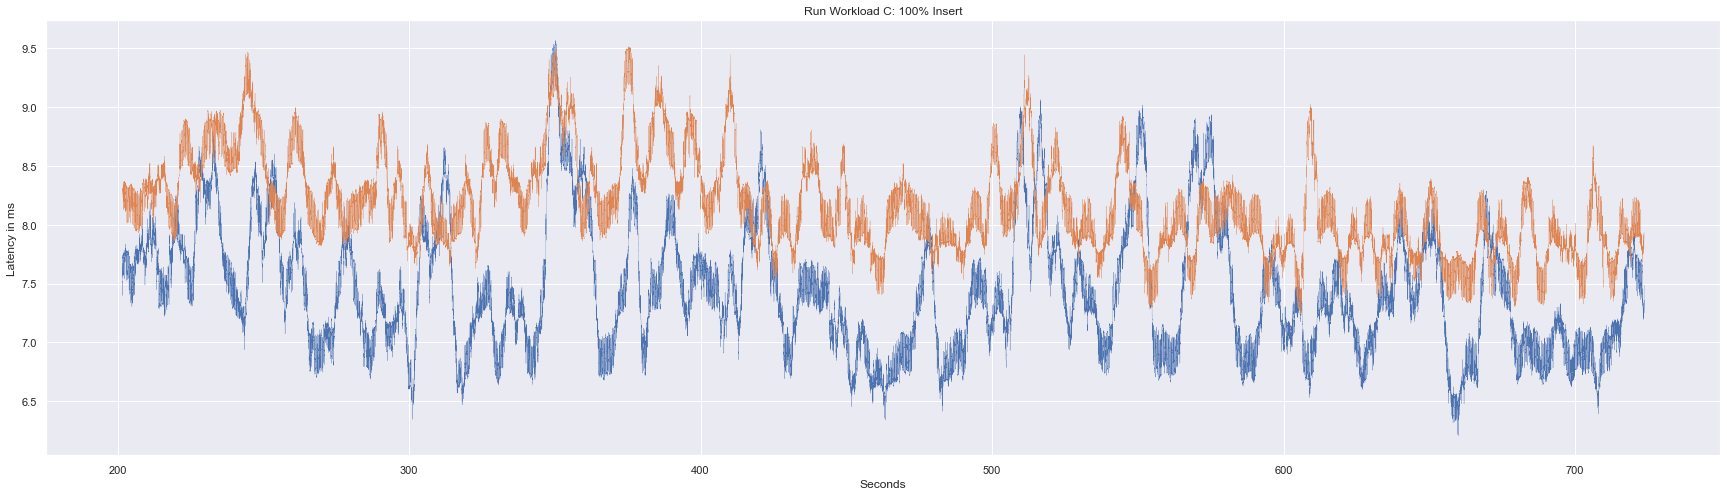

In [216]:
subchartA = dfA[['sent_sec', 'latency_ms']]
subchartB = dfB[['sent_sec', 'latency_ms']]
subchartA["100sec_average"] = subchartA.latency_ms.rolling(5000).mean().shift(-2500)
subchartB["100sec_average"] = subchartB.latency_ms.rolling(5000).mean().shift(-2500)

p = sns.lineplot(data=subchartA, x="sent_sec", y="100sec_average", linewidth=0.25)
title =  phase + " " + workloadLoad  if phase=="Run" else phase
sns.lineplot(data=subchartB, x='sent_sec',y='100sec_average', linewidth=0.25).set_title(title)
p.set_xlabel("Seconds");
p.set_ylabel("Latency in ms");
